In [1]:
pwd

'/mnt/d/VR/PostPhD/JOB/QKrishi/3_Interns/Projects/2_Quantum_Finance/PO/Work/Ishan'

In [2]:
!date

Thu Jun 30 09:44:17 IST 2022


In [3]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [4]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


In [5]:
# set number of assets (= number of qubits)
num_assets = 2
seed = 123

# Generate expected return and covariance matrix from (random) time-series
#stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(
#     tickers=stocks,
#     start=datetime.datetime(2016, 1, 1),
#     end=datetime.datetime(2016, 1, 30),
#     seed=seed,
# )



#### Using data from yahoo finance
data = YahooDataProvider(
        tickers=["WMT","INTC"],
        start=datetime.datetime(2015, 9, 1),
        end=datetime.datetime(2020, 9, 1),
    )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


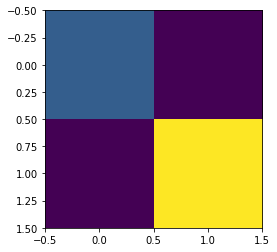

In [6]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [7]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000801190687 x_0 - 0.000779629555 x_1 + [ 0.000202143873 x_0^2
      + 0.000215748086 x_0*x_1 + 0.000422770414 x_1^2 ]/2
Subject To
 c0: x_0 + x_1 = 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_1
End

In [8]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))


In [9]:

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)


Optimal: selection [1. 0.], value -0.0007

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
     [1 0]	-0.0007		1.0000
     [1 1]	1.0008		0.0000
     [0 1]	-0.0006		0.0000
     [0 0]	1.0020		0.0000


In [10]:
#### VQE solution

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


Optimal: selection [1. 0.], value -0.0007

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
     [1 0]	-0.0007		0.9999
     [0 1]	-0.0006		0.0001
     [1 1]	1.0008		0.0000
     [0 0]	1.0020		0.0000


In [11]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [1. 0.], value -0.0007

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
     [0 1]	-0.0006		0.5000
     [1 0]	-0.0007		0.5000
     [0 0]	1.0020		0.0000
     [1 1]	1.0008		0.0000


In [12]:
stocks = ["GOOG", "AAPL"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2016, 1, 30),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


In [13]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")


In [14]:
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")


In [20]:
print(data)

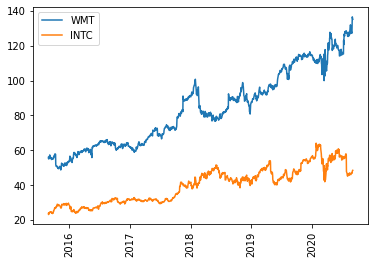

In [21]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [22]:
for (cnt, s) in enumerate(data._tickers):
    print(data._data[cnt])

Date
2015-08-31     55.947124
2015-09-01     55.160595
2015-09-02     55.696461
2015-09-03     56.059471
2015-09-04     55.221085
                 ...    
2020-08-25    127.161018
2020-08-26    127.229172
2020-08-27    133.001694
2020-08-28    136.574234
2020-08-31    135.162766
Name: Adj Close, Length: 1260, dtype: float64
Date
2015-08-31    23.778904
2015-09-01    23.179014
2015-09-02    23.828892
2015-09-03    24.228811
2015-09-04    23.762238
                ...    
2020-08-25    47.098858
2020-08-26    47.213200
2020-08-27    47.070274
2020-08-28    48.051693
2020-08-31    48.547173
Name: Adj Close, Length: 1260, dtype: float64


In [23]:
for (cnt, s) in enumerate(data._tickers):
    print(type(data._data[cnt]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
